In [35]:
import mujoco
import mujoco.mjx as mjx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def alpha_order_grad(cost_fn, u, eps=1e-3, M=32, gamma=1.0, key=jax.random.PRNGKey(0)):
    """Adaptive alpha-order gradient for scalar J(u) with u.shape=(1,) or (m,)."""
    n = u.size
    k1, k0 = jax.random.split(key)
    Z1 = jax.random.normal(k1, (M, n))
    Z0 = jax.random.normal(k0, (M, n))

    # FoBG samples (pathwise)
    grad1_s = jax.vmap(lambda z: jax.grad(cost_fn)(u + eps*z))(Z1)
    grad1   = jnp.mean(grad1_s, axis=0)

    # ZoBG samples (REINFORCE/FD)
    f0 = cost_fn(u)
    grad0_s = jax.vmap(lambda z: (f0 - cost_fn(u + eps*z)) * z / eps)(Z0)
    grad0   = jnp.mean(grad0_s, axis=0)

    # Adaptive α (Suh et al. Eq. 4–5, robust rule)
    var1 = jnp.mean(jnp.sum((grad1_s - grad1)**2, axis=1))
    var0 = jnp.mean(jnp.sum((grad0_s - grad0)**2, axis=1))
    B = jnp.linalg.norm(grad1 - grad0)
    eps_conf = jnp.sqrt(var0 / M)
    alpha_inf = var0 / (var0 + var1 + 1e-12)
    alpha = jnp.where(alpha_inf * B <= (gamma - eps_conf),
                      alpha_inf,
                      jnp.clip((gamma - eps_conf) / (B + 1e-12), 0.0, 1.0))
    grad_mix = alpha * grad1 + (1.0 - alpha) * grad0
    return grad_mix, alpha, (grad1, grad0)


In [31]:
0.01*50

0.5

In [52]:
# ---- 1-DoF MuJoCo model (slide joint along z) ----
xml = """
<mujoco>
  <option timestep="0.02" gravity="0 0 -9.81"/>
  <worldbody>
    <body name="ball" pos="0 0 1.0">
      <joint name="slide_z" type="slide" axis="0 0 1" limited="true" range="0 2"/>
      <geom type="sphere" size="0.05" mass="0.2" condim="3"/>
    </body>
    <geom type="plane" size="1 1 0.05" pos="0 0 0"/>
  </worldbody>
  <actuator>
    <motor joint="slide_z" ctrlrange="-20 20"/>
  </actuator>
</mujoco>
"""

# ====== Rollout (sequence-ready) ======
def rollout_mjx(mjx_model, mjx_data0, u_seq):
    """
    Simulate control sequence u_seq over horizon len(u_seq)
    Returns:
        q_hist: (T+1, nq)
        v_hist: (T+1, nv)
    """
    def step_fn(d, u_t):
        d = d.replace(ctrl=u_t[None])       # (1,) for single actuator
        d_next = mjx.step(mjx_model, d)
        return d_next, (d.qpos, d.qvel)

    data0 = mjx_data0.replace(qpos=jnp.array([1.0]), qvel=jnp.array([0.0]))
    data_final, (q_hist, v_hist) = jax.lax.scan(step_fn, data0, u_seq)
    # Append final state
    q_hist = jnp.vstack([q_hist, data_final.qpos[None, :]])
    v_hist = jnp.vstack([v_hist, data_final.qvel[None, :]])
    return q_hist, v_hist


# ====== Cost function (sequence-ready) ======
def make_cost_fn(mjx_model, mjx_data0, z_target=1.2, w_u=1e-2):
    """
    Returns a callable cost_fn(u_seq) that uses rollout_mjx internally.
    """
    def cost_fn(u_seq):
        q_hist, v_hist = rollout_mjx(mjx_model, mjx_data0, u_seq)
        zT = q_hist[-1, 0]
        cost_terminal = 0.5 * (zT - z_target)**2
        cost_ctrl = 0.5 * w_u * jnp.sum(u_seq**2)
        return cost_terminal + cost_ctrl
    return cost_fn

In [63]:
T = 50                 # 1 second
z_target = 1.2
w_u = 1e-2

# Build model and data
m = mujoco.MjModel.from_xml_string(xml)
d0 = mujoco.MjData(m)
mjx_model = mjx.put_model(m)
mjx_data0 = mjx.put_data(m, d0)

dt = float(m.opt.timestep)

u0 = jnp.array([0.1])
u_seq = jnp.zeros(T).at[0].set(u0[0])   # first control, rest zeros
cost_fn = make_cost_fn(mjx_model, mjx_data0)
J = cost_fn(u_seq)
print("cost:", float(J))


# grad_pathwise = jax.jacfwd(cost_mjx)(u_seq0)

cost: 0.7210597991943359


In [64]:
def cost_single(u0):
    u_seq = jnp.zeros(T).at[0].set(u0[0])
    return cost_fn(u_seq)

g_single = jax.jacfwd(cost_single)(jnp.array([0.0]))   # FoBG (forward mode)

In [65]:
g_single

Array([5.4110435e-11], dtype=float32)

In [49]:
u_test = [0.0, 10.0, -10.0]
for u in u_test:
    q_hist, v_hist = rollout_mjx(jnp.ones(T)*u)
    print(f"u={u:5.1f} -> z_final={float(q_hist[-1,0]):.3f}")

u=  0.0 -> z_final=-0.001
u= 10.0 -> z_final=2.003
u=-10.0 -> z_final=-0.005


In [51]:
mjx_data0 = mjx_data0.replace(ctrl=jnp.array([u]))
data_next = mjx.step(mjx_model, mjx_data0)
print("actuator force:", data_next.qfrc_actuator)

actuator force: [-10.]


In [47]:
u_seq0 = jnp.zeros(T)*10
q_hist, v_hist = rollout_mjx(u_seq0)
q_hist

Array([[ 1.0000000e+00],
       [ 9.9607599e-01],
       [ 9.8822796e-01],
       [ 9.7645599e-01],
       [ 9.6076000e-01],
       [ 9.4114000e-01],
       [ 9.1759598e-01],
       [ 8.9012796e-01],
       [ 8.5873598e-01],
       [ 8.2341999e-01],
       [ 7.8417999e-01],
       [ 7.4101597e-01],
       [ 6.9392794e-01],
       [ 6.4291596e-01],
       [ 5.8797997e-01],
       [ 5.2911997e-01],
       [ 4.6633598e-01],
       [ 3.9962798e-01],
       [ 3.2899600e-01],
       [ 2.5444001e-01],
       [ 1.7596003e-01],
       [ 9.3556054e-02],
       [ 7.2280741e-03],
       [-8.3023906e-02],
       [-6.2463988e-02],
       [-4.5828070e-02],
       [-3.3116151e-02],
       [-2.4328234e-02],
       [-1.8442376e-02],
       [-1.4027982e-02],
       [-1.0717186e-02],
       [-8.2340892e-03],
       [-6.3717663e-03],
       [-4.9750246e-03],
       [-3.9274688e-03],
       [-3.1418018e-03],
       [-2.5525515e-03],
       [-2.1106135e-03],
       [-1.7791600e-03],
       [-1.5305697e-03],


In [39]:
grad_pathwise.shape

(50,)

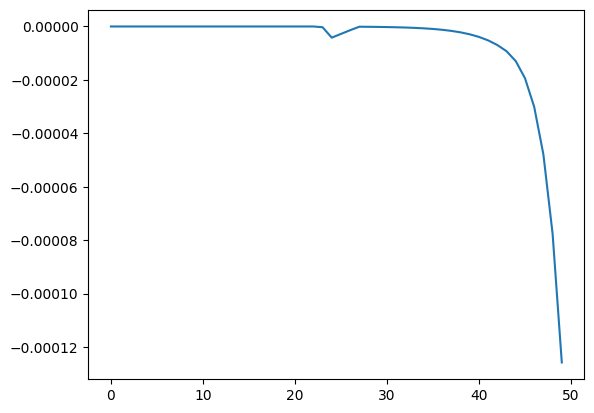

In [40]:
plt.plot(grad_pathwise)

In [12]:
u0 = jnp.array([0.0])
rollout_final_height(u0)

Array(-0.00036674, dtype=float32)

In [9]:
import mujoco
m = mujoco.MjModel.from_xml_string(xml)
print("Joints:", [m.joint(i).name for i in range(m.njnt)])


Joints: ['slide_z']
